In [1]:
from transfer_em.datasets import datasets, generators
from transfer_em import debug
import tensorflow as tf

In [2]:
# create dataset of 3D datasets using dvid to fetch cubes randomly from larger dataset
dvid_server = "http://emdata3.int.janelia.org:8600" # choose some accessible dvid server
uuid = "a89e"
instance = "grayscale"
bbox = ((8000, 14000, 13000), (30000, 28000, 25000)) # x,y,z, x2,y2,z2

# choose larger volume and smaller batches of 8 -- for non-example one should have ~512 batches not just 8
generator = generators.volume3d_dvid(dvid_server, uuid, instance, bbox, 64)

# will take some time to download the whole dataset for the first time
train_f, meanstd_f = datasets.create_dataset_from_generator(generator, (64,64,64), custom_map=debug.warp_tensor, batch_size=8, epoch_size=64)
train_g, meanstd_g = datasets.create_dataset_from_generator(generator, (64,64,64), batch_size=8, epoch_size=64)

In [4]:
# create a test set for evaluation -- set seed to get same sequence

generator = generators.volume3d_dvid(dvid_server, uuid, instance, bbox, 64, 10) # set seed for repeatability

test_dataset, _ = datasets.create_dataset_from_generator(generator, (64,64,64), custom_map=debug.warp_tensor, meanstd=meanstd_f, batch_size=1, epoch_size=1)
test_dataset_gt, _ = datasets.create_dataset_from_generator(generator, (64,64,64), meanstd=meanstd_g, batch_size=1, epoch_size=1)

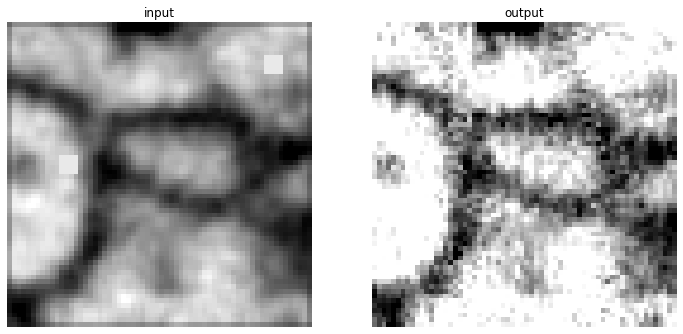

In [6]:
# get a sample from the test dataset and view
sample = next(iter(test_dataset))
sample_gt = next(iter(test_dataset_gt))
from transfer_em.debug import generate_images
#sample_gt = datasets.unstandardize_population(sample_gt, meanstd_g)
generate_images(sample, sample_gt)

In [7]:
# create EM2EM network with 128x128 image and provide an experiment name for checkpointing
from transfer_em.cgan import EM2EM
em2em = EM2EM(32, "example3d", is3d=True)#, ckpt_restore="./checkpoints/train_example2d/ckpt-3")

Accuracy on sample: 0.41323530673980713


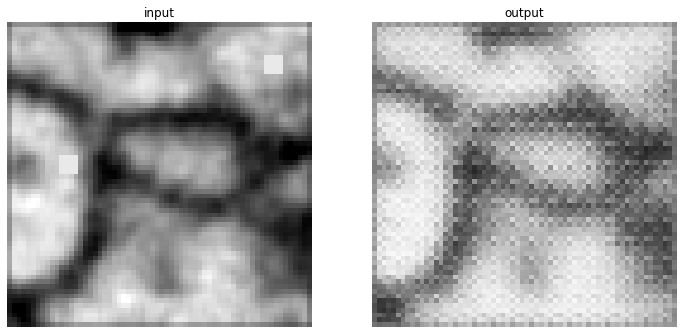

Time taken for epoch 5 is 112.55001997947693


In [8]:
# train for 5 EPOCHS
em2em.train(train_f, train_g, 5, 0, True, sample, sample_gt, num_samples=64//8)

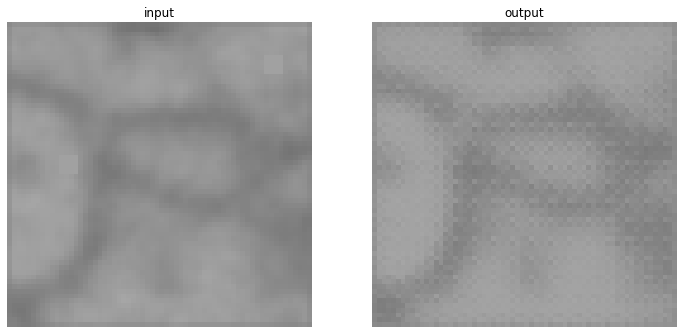

0.4132353


In [9]:
# run prediction on the sample (64 image batch)
sample_pred = em2em.predict(sample)

# rescale based on f's meanstd
sample_unstd = datasets.unstandardize_population(sample, meanstd_f)

# rescale prediction based on g's meanstd
sample_pred_unstd = datasets.unstandardize_population(sample_pred, meanstd_g)

# view final results
generate_images(sample_unstd, sample_pred_unstd)

# view accuracy using RMSE for first image
print(debug.accuracy(sample_gt, sample_pred))